In [1]:
import os
import numpy as np
import pandas as pd
from time import time
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import copy
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

In [3]:
import torch
from torch import nn
from torch.autograd import Variable

class ET_Rnn(torch.nn.Module):
    def __init__(self, dense_dims, sparse_dims, hidden_dims, n_layers=1, use_chid=True, cell='GRU', bi=False, dropout=0, device='cpu'):
        super(ET_Rnn, self).__init__()
        self.hidden_dims = hidden_dims
        self.n_layers = n_layers
        self.cell = cell
        self.use_chid = use_chid
        self.device = device
        self.bi = bi
        
        self.embedding_list = nn.ModuleList([nn.Embedding(fd, ed, padding_idx=0) for fd, ed in sparse_dims])
        
        if use_chid: 
            rnn_in_dim = dense_dims + sum([ed for fd, ed in sparse_dims[1:]])   
            self.out_dim = hidden_dims*(bi+1) + sparse_dims[0][1] # chid embed dim
            self.user_layer = nn.Linear(sparse_dims[0][1], sparse_dims[0][1]) 
            
        else:
            rnn_in_dim = dense_dims + sum([ed for fd, ed in sparse_dims[:]])
            self.out_dim = hidden_dims*(bi+1)
        
        if self.cell == 'LSTM':
            self.rnn = nn.LSTM(rnn_in_dim, hidden_dims, n_layers, batch_first=True, bidirectional=bi, dropout=dropout)
        elif self.cell == 'GRU':
            self.rnn = nn.GRU(rnn_in_dim, hidden_dims, n_layers, batch_first=True, bidirectional=bi, dropout=dropout)    
        
        self.init_embedding()
        
    def init_embedding(self):
        for embed in self.embedding_list:
            embed.reset_parameters()

    def init_hidden(self, x):
        if self.cell == 'LSTM':
            hidden = Variable(torch.zeros(self.n_layers*(self.bi+1), x.size(0), self.hidden_dims)).to(self.device)
            context = Variable(torch.zeros(self.n_layers*(self.bi+1), x.size(0), self.hidden_dims)).to(self.device)
            ret = (hidden, context)
        elif self.cell == 'GRU':
            hidden = Variable(torch.zeros(self.n_layers*(self.bi+1), x.size(0), self.hidden_dims)).to(self.device)
            ret = hidden
        
        return ret
            
    def forward(self, x_dense, x_sparse):
        if self.use_chid:
            x = torch.cat([x_dense]+[embed(x_sparse[:, :, i+1]) for i, embed in enumerate(self.embedding_list[1:])], dim=-1)            
        else:
            x = torch.cat([x_dense]+[embed(x_sparse[:, :, i]) for i, embed in enumerate(self.embedding_list[:])], dim=-1)
        
        self.hidden = self.init_hidden(x)
        logits, self.hidden = self.rnn(x, self.hidden)
        
        if self.use_chid:
            user_embed = self.user_layer(self.embedding_list[0](x_sparse[:,0,0]))
            last_logits = torch.cat([logits[:, -1], user_embed], dim=-1)
        else:
            last_logits = logits[:, -1]
        
        return last_logits

In [4]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims=[1], out_dim=1):
        super(MLP, self).__init__()
        hidden_dims = [input_dims] + hidden_dims
        
        self.layers = nn.Sequential(*[
            nn.Sequential(
                nn.Linear(idim, odim), 
                nn.ReLU()
            ) for idim, odim in zip(hidden_dims[:-1], hidden_dims[1:])
        ])
        
        self.out_layer = nn.Linear(hidden_dims[-1], out_dim)
                   
    def forward(self, x):
        out = self.layers(x)
        out = self.out_layer(out)
        
        return out

In [5]:
class MultiTaskModel(nn.Module):
    def __init__(self, dense_dims, sparse_dims, hidden_dims, out_dims=[1], n_layers=1, use_chid=True, cell='GRU', bi=False, dropout=0, device='cpu'):
        super(MultiTaskModel, self).__init__()
        self.rnn = ET_Rnn(dense_dims, sparse_dims, hidden_dims, n_layers=n_layers, use_chid=use_chid, 
                          cell=cell, bi=bi, dropout=dropout, device=device)
        
        self.mlps = nn.ModuleList([MLP(self.rnn.out_dim, hidden_dims=[self.rnn.out_dim//2], out_dim=od) for od in out_dims])
        
    def forward(self, x_dense, x_sparse):
        logits = self.rnn(x_dense, x_sparse)
        outs = [mlp(logits)for mlp in self.mlps]
        
        return outs        

In [6]:
class Trainer:
    def __init__(self, model, optimizer, device='cpu'):
        self.model = model.to(device)
        self.criterion_reg = nn.MSELoss()
        self.criterion_clf = nn.CrossEntropyLoss()
        self.optimizer = optimizer
        self.device = device
        
    def fit(self, train_loader, test_loader=None, epoch=1, early_stop=-1, scaler=None):
        history = {
            'train': [], 
            'test': []
        }
        
        best_eval = 9e9
        early_cnt = 0
        best_model_params = copy.deepcopy(self.model.state_dict())
        
        for ep in tqdm(range(epoch)):
            #print('Epoch:{}'.format(ep+1))
            
            self.model.train()
            for batch in train_loader:
                loss = 0
                self.optimizer.zero_grad()
                
                batch = [b.to(self.device) for b in batch]
                x_dense, x_sparse = batch[:2]
                task = batch[2:]
                
                #x_dense, x_sparse, task_0, task_1, task_2, task_3 = [b.to(self.device) for b in batch]
                
                outputs = self.model(x_dense, x_sparse)
                
                reg_num = 3
                for i in range(reg_num):
                    loss += self.criterion_reg(outputs[i], task[i])
                for i in range(reg_num, 4):
                    loss += self.criterion_clf(outputs[i], task[i])

                loss.backward()
                self.optimizer.step()
                
            train_result, _, _ = self.evaluate(train_loader)
            history['train'].append(train_result)
            #print('\ttrain\t'+' '.join(['{}:{:.2f}'.format(k, v) for k, v in train_result.items()]))
            
            if test_loader:
                test_result, _, _ = self.evaluate(test_loader)
                history['test'].append(test_result)
                
                if ep%5 == 0 or ep == epoch-1:
                    print('Epoch:{}'.format(ep+1))
                    print('\ttest\t'+' '.join(['{}:{:.3f}'.format(k, v) for k, v in test_result.items()]))

                if test_result['total_loss'] < best_eval:
                    early_cnt = 0
                    best_eval = test_result['total_loss']
                    best_model_params = copy.deepcopy(self.model.state_dict())
                    #print('\tbetter!')

                elif early_stop > 0:
                    early_cnt += 1

            if early_stop > 0 and early_cnt >= early_stop:
                break
        
        self.model.load_state_dict(best_model_params)
        
        return history
        
    def evaluate(self, loader):
        true_list = [[] for i in range(4)]
        pred_list = [[] for i in range(4)]
        total_loss = 0
        loss_list = [0]*4
        reg_num = 3
        
        self.model.eval()
        for batch in loader:
            batch = [b.to(self.device) for b in batch]
            x_dense, x_sparse = batch[:2]
            task = batch[2:]
            
            outputs = self.model(x_dense, x_sparse)         
            
            for i, (y, output) in enumerate(zip(task, outputs)):
                true_list[i].append(y.cpu().detach().numpy())
                pred_list[i].append(output.cpu().detach().numpy())
                
                if i < reg_num:
                    batch_loss = self.criterion_reg(output, y).cpu().detach().item() * y.shape[0]
                else:
                    batch_loss = self.criterion_clf(output, y).cpu().detach().item() * y.shape[0]
                    
                total_loss += batch_loss
                loss_list[i] += batch_loss

        for i in range(reg_num):
            true_list[i] = np.expm1(np.concatenate(true_list[i], axis=0))
            pred_list[i] = np.expm1(np.concatenate(pred_list[i], axis=0))
            
        for i in range(reg_num, 4):
            true_list[i] = np.concatenate(true_list[i], axis=0).reshape(-1, 1)
            pred_list[i] = np.argmax(np.concatenate(pred_list[i], axis=0), axis=1).reshape(-1, 1)                         
        
        # objsum, tscnt, spcnt, label_0, label_mul
        result = {
            'total_loss': total_loss/len(loader.dataset), 
            'objsum': mean_squared_error(true_list[0], pred_list[0], squared=False), 
            'tscnt': mean_squared_error(true_list[1], pred_list[1], squared=False), 
            'spcnt': mean_squared_error(true_list[2], pred_list[2], squared=False), 
            'label_0': accuracy_score(true_list[3], pred_list[3]),
        }
        
        return result, true_list, pred_list

In [7]:
sample_path = './data/sample_50k'

x_train = np.load(os.path.join(sample_path, 'RNN', 'x_train.npy'), allow_pickle=True)
x_test = np.load(os.path.join(sample_path, 'RNN', 'x_test.npy'), allow_pickle=True)

#f_train = np.load(os.path.join(sample_path, 'RNN', 'f_train.npy'), allow_pickle=True)
#f_test = np.load(os.path.join(sample_path, 'RNN', 'f_test.npy'), allow_pickle=True)

Y_train = np.load(os.path.join(sample_path, 'RNN', 'y_train.npy'), allow_pickle=True)
Y_test = np.load(os.path.join(sample_path, 'RNN', 'y_test.npy'), allow_pickle=True)

chid_mapper = np.load(os.path.join(sample_path, 'sample_50k_chid_idx_map.npy'), allow_pickle=True).item()
feat_mapper = np.load(os.path.join(sample_path, 'RNN', 'feature_map.npy'), allow_pickle=True).item()
cust_feature_map = np.load(os.path.join(sample_path, 'RNN', 'cust_feature_map.npy'), allow_pickle=True).item()

columns = np.load(os.path.join(sample_path, 'RNN', 'columns.npy'), allow_pickle=True).item()

print(x_train.shape, x_test.shape, Y_train.shape, Y_test.shape, len(chid_mapper))
print([(k, len(v)) for k, v in feat_mapper.items()], [(k, len(v)) for k, v in cust_feature_map.items()])

(1033871, 120, 14) (100000, 120, 14) (1033871, 7) (100000, 7) 50000
[('bnsfg', 2), ('iterm', 15), ('mcc', 507), ('scity', 11074), ('stonc_tag', 49), ('stonc_label', 202387), ('stonm_label', 212342), ('stonc_6_label', 78560), ('stonc_10_label', 128075)] [('masts', 3), ('educd', 6), ('trdtp', 27), ('poscd', 9)]


In [8]:
category_cols = columns['x_columns'][:-4]
numeric_cols = columns['x_columns'][-4:]

print(columns['x_columns'])
print(category_cols, numeric_cols)

['chid', 'bnsfg', 'iterm', 'mcc', 'scity', 'stonc_tag', 'stonc_label', 'stonm_label', 'stonc_6_label', 'stonc_10_label', 'bnspt', 'timestamp_0', 'timestamp_1', 'objam']
['chid', 'bnsfg', 'iterm', 'mcc', 'scity', 'stonc_tag', 'stonc_label', 'stonm_label', 'stonc_6_label', 'stonc_10_label'] ['bnspt', 'timestamp_0', 'timestamp_1', 'objam']


In [9]:
print(columns['y_columns'])

['chid', 'data_dt', 'objam_sum', 'objam_mean', 'trans_count', 'shop_count', 'objam_mean_M3_diff']


In [10]:
# regession
index = columns['y_columns'].index('objam_sum')
train_objsum = Y_train[:, [index]].astype(np.float64)
test_objsum = Y_test[:, [index]].astype(np.float64)

#index = columns['y_columns'].index('objam_mean')
#train_objmean = Y_train[:, [index]].astype(np.float64)
#test_objmean = Y_test[:, [index]].astype(np.float64)

index = columns['y_columns'].index('trans_count')
train_tscnt = Y_train[:, [index]].astype(np.float64)
test_tscnt = Y_test[:, [index]].astype(np.float64)

index = columns['y_columns'].index('shop_count')
train_spcnt = Y_train[:, [index]].astype(np.float64)
test_spcnt = Y_test[:, [index]].astype(np.float64)

In [11]:
#classfication
bounds = [0]
lable_trans = np.vectorize(lambda x: sum([x > bound for bound in bounds]))

train_label_0 = lable_trans(train_objsum)
test_label_0 = lable_trans(test_objsum)

bounds = [0, 1e4, 5e4, 1e5, 3e5]
lable_trans = np.vectorize(lambda x: sum([x > bound for bound in bounds]))
train_label_mul = lable_trans(train_objsum)
test_label_mul = lable_trans(test_objsum)

print(np.unique(train_label_mul).shape[0], np.unique(test_label_mul).shape[0], train_label_mul.shape, test_label_mul.shape)

6 6 (1033871, 1) (100000, 1)


In [12]:
# log transform
train_objsum = np.log1p(train_objsum)
test_objsum = np.log1p(test_objsum)

#train_objmean = np.log1p(train_objmean)
#test_objmean = np.log1p(test_objmean)

train_tscnt = np.log1p(train_tscnt)
test_tscnt = np.log1p(test_tscnt)

train_spcnt = np.log1p(train_spcnt)
test_spcnt = np.log1p(test_spcnt)

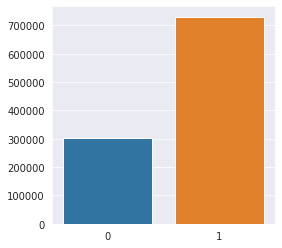

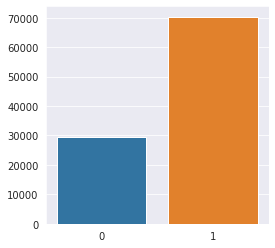

In [13]:
train_label_num = [np.sum(train_label_0 == label) for label in sorted(np.unique(train_label_0))]
test_label_num = [np.sum(test_label_0 == label) for label in sorted(np.unique(train_label_0))]

with sns.axes_style("darkgrid"):
    plt.figure(figsize=(4, 4))
    sns.barplot(x=[0, 1], y=train_label_num)
    plt.xticks(range(len(train_label_num)))
    plt.show()
    
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(4, 4))
    sns.barplot(x=[0, 1], y=test_label_num)
    plt.xticks(range(len(test_label_num)))
    plt.show()

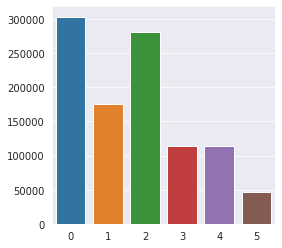

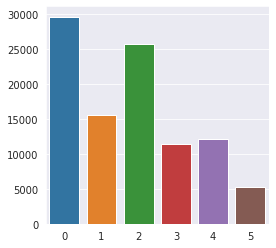

In [14]:
train_label_num = [np.sum(train_label_mul == label) for label in sorted(np.unique(train_label_mul))]
test_label_num = [np.sum(test_label_mul == label) for label in sorted(np.unique(train_label_mul))]

with sns.axes_style("darkgrid"):
    plt.figure(figsize=(4, 4))
    sns.barplot(x=sorted(np.unique(train_label_mul)), y=train_label_num)
    plt.xticks(range(len(train_label_num)))
    plt.show()
    
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(4, 4))
    sns.barplot(x=sorted(np.unique(train_label_mul)), y=test_label_num)
    plt.xticks(range(len(test_label_num)))
    plt.show()

In [15]:
sparse_feat = category_cols[:5]#+['stonc_tag', 'stonc_6_label']
dense_feat = numeric_cols

keys = list(feat_mapper.keys())
for key in keys:
    if key not in sparse_feat:
        del feat_mapper[key]

print(sparse_feat, [(k, len(v)) for k, v in feat_mapper.items()])

['chid', 'bnsfg', 'iterm', 'mcc', 'scity'] [('bnsfg', 2), ('iterm', 15), ('mcc', 507), ('scity', 11074)]


In [16]:
USE_CHID = True
idx_start = 1-int(USE_CHID)
sparse_index = [category_cols.index(feat) for feat in sparse_feat][idx_start:]

chid_embed_dim = 64
feat_embed_dim = 16

dense_dims = len(dense_feat) # number of dense feature
feat_dims = np.array([len(chid_mapper)] + [len(v) for v in feat_mapper.values()])+1 # 0 is padding index, so add 1 dims
embed_dims = [chid_embed_dim]+[feat_embed_dim]*len(feat_mapper) # dims of chid and other sparse feature

sparse_dims = [(fd, ed) for fd, ed in zip(feat_dims[idx_start:], embed_dims[idx_start:])]

dense_dims, sparse_dims, sparse_index

(4, [(50001, 64), (3, 16), (16, 16), (508, 16), (11075, 16)], [0, 1, 2, 3, 4])

In [17]:
# x_data
w_size = x_train.shape[1]

x_scaler = MinMaxScaler(feature_range=(0, 1))

x_train_dense = x_train[:, -w_size:, len(category_cols):].astype(np.float64) # split dense feature
x_train_sparse = x_train[:, -w_size:, sparse_index].astype(np.int64) # split sparse feature

x_train_dense = np.log1p(x_train_dense - x_train_dense.min(axis=0))
x_train_dense = x_scaler.fit_transform(x_train_dense.reshape(-1, x_train_dense.shape[-1])).reshape(x_train_dense.shape)

x_test_dense = x_test[:, -w_size:, len(category_cols):].astype(np.float64)
x_test_sparse = x_test[:, -w_size:, sparse_index].astype(np.int64) 

x_test_dense = np.log1p(x_test_dense - x_test_dense.min(axis=0))
x_test_dense = x_scaler.transform(x_test_dense.reshape(-1, x_test_dense.shape[-1])).reshape(x_test_dense.shape)

In [18]:
print(x_train_dense.shape, x_train_sparse.shape)
print(x_test_dense.shape, x_test_sparse.shape)

(1033871, 120, 4) (1033871, 120, 5)
(100000, 120, 4) (100000, 120, 5)


In [19]:
# train_objsum
# test_objsum

# train_tscnt
# test_tscnt

# train_spcnt
# test_spcnt

# train_label_0
# test_label_0

# train_label_mul
# test_label_mul

In [20]:
batch_size = 2048

train_dataset = TensorDataset(torch.FloatTensor(x_train_dense), torch.LongTensor(x_train_sparse), 
                              torch.FloatTensor(train_objsum), torch.FloatTensor(train_tscnt), 
                              torch.FloatTensor(train_spcnt), torch.LongTensor(train_label_0.flatten()))

train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size, num_workers=8)

test_dataset = TensorDataset(torch.FloatTensor(x_test_dense), torch.LongTensor(x_test_sparse), 
                              torch.FloatTensor(test_objsum), torch.FloatTensor(test_tscnt), 
                             torch.FloatTensor(test_spcnt), torch.LongTensor(test_label_0.flatten()))

test_loader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=batch_size, num_workers=8)

In [21]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
out_dims = [1, 1, 1, 2]

model = MultiTaskModel(dense_dims, sparse_dims, hidden_dims=64, out_dims=out_dims, n_layers=2, 
                       use_chid=USE_CHID, cell='GRU', bi=False, dropout=0.1, device=device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)

print(device)
model

cuda:1


MultiTaskModel(
  (rnn): ET_Rnn(
    (embedding_list): ModuleList(
      (0): Embedding(50001, 64, padding_idx=0)
      (1): Embedding(3, 16, padding_idx=0)
      (2): Embedding(16, 16, padding_idx=0)
      (3): Embedding(508, 16, padding_idx=0)
      (4): Embedding(11075, 16, padding_idx=0)
    )
    (user_layer): Linear(in_features=64, out_features=64, bias=True)
    (rnn): GRU(68, 64, num_layers=2, batch_first=True, dropout=0.1)
  )
  (mlps): ModuleList(
    (0): MLP(
      (layers): Sequential(
        (0): Sequential(
          (0): Linear(in_features=128, out_features=64, bias=True)
          (1): ReLU()
        )
      )
      (out_layer): Linear(in_features=64, out_features=1, bias=True)
    )
    (1): MLP(
      (layers): Sequential(
        (0): Sequential(
          (0): Linear(in_features=128, out_features=64, bias=True)
          (1): ReLU()
        )
      )
      (out_layer): Linear(in_features=64, out_features=1, bias=True)
    )
    (2): MLP(
      (layers): Sequential

In [22]:
t0 = time()
trainer = Trainer(model, optimizer, device)
history = trainer.fit(train_loader, test_loader, epoch=100, early_stop=20)
t1 = time()

print('cost: {:.2f}'.format(t1 - t0))

Epoch:1
	test	total_loss:12.408 objsum:604031.188 tscnt:15.548 spcnt:2.794 label_0:0.849
Epoch:6
	test	total_loss:11.829 objsum:583744.000 tscnt:13.998 spcnt:2.398 label_0:0.853
Epoch:11
	test	total_loss:11.827 objsum:560961.750 tscnt:11.978 spcnt:2.398 label_0:0.851
Epoch:16
	test	total_loss:11.666 objsum:546979.625 tscnt:11.473 spcnt:2.459 label_0:0.854
Epoch:21
	test	total_loss:11.741 objsum:555490.062 tscnt:11.883 spcnt:2.358 label_0:0.853
Epoch:26
	test	total_loss:11.815 objsum:534492.438 tscnt:8.480 spcnt:2.353 label_0:0.852
Epoch:31
	test	total_loss:11.895 objsum:513683.844 tscnt:12.029 spcnt:2.431 label_0:0.852
Epoch:36
	test	total_loss:12.114 objsum:476834.562 tscnt:10.039 spcnt:2.357 label_0:0.850

cost: 4524.42


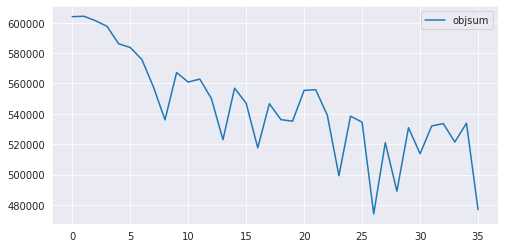

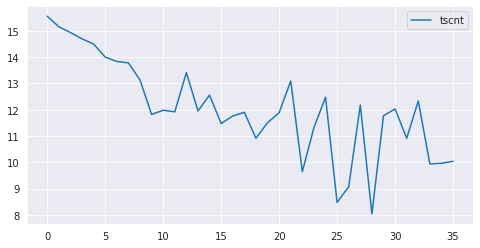

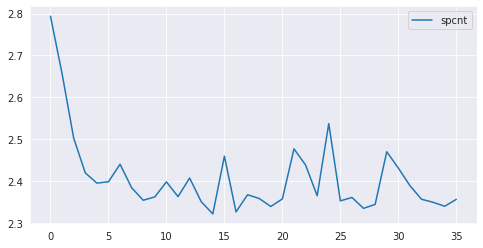

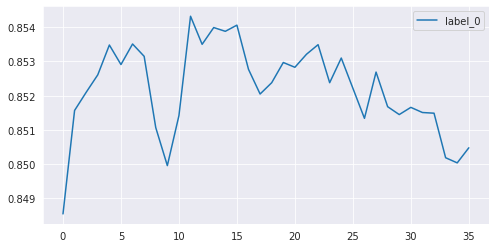

In [23]:
df_history = pd.DataFrame(history['test'])

# objsum, tscnt, spcnt, label_0, label_mul
cols = ['objsum', 'tscnt', 'spcnt', 'label_0']

for show in cols:
    with sns.axes_style("darkgrid"):
        plt.figure(figsize=(8, 4))
        sns.lineplot(data=pd.DataFrame(df_history[show]))
        plt.show()

In [24]:
train_result, train_true_list, train_pred_list = trainer.evaluate(train_loader)
test_result, test_true_list, test_pred_list = trainer.evaluate(test_loader)

print('train\t'+' '.join(['{}:{:.4f}'.format(k, v) for k, v in train_result.items()]))
print('test\t'+' '.join(['{}:{:.4f}'.format(k, v) for k, v in test_result.items()]))

train	total_loss:12.8595 objsum:827075.0000 tscnt:5.1102 spcnt:2.0506 label_0:0.8353
test	total_loss:11.6663 objsum:546979.6250 tscnt:11.4733 spcnt:2.4594 label_0:0.8541


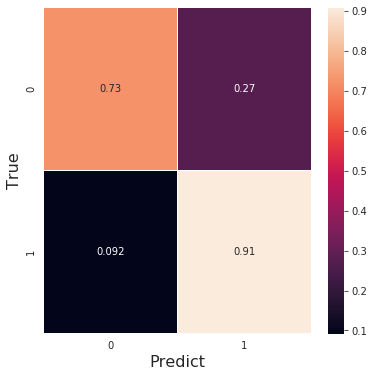

-1 {'AccuracyScore': 0.8541, 'RecallScore': 0.8168, 'PrecisionScore': 0.8281, 'F1Score': 0.8221}


In [28]:
label_num = 1

for i in range(1, label_num+1):
    cf_matrix = confusion_matrix(test_true_list[-i].reshape(-1, 1), test_pred_list[-i].reshape(-1, 1), normalize='true')
    
    with sns.axes_style("darkgrid"):
        plt.figure(figsize=(6, 6))
        ax = sns.heatmap(cf_matrix, linewidths=.01, annot=True)
        ax.set_xlabel('Predict', fontsize=16)
        ax.set_ylabel('True', fontsize=16)
        plt.show()    

        scores = {
            'AccuracyScore': round(accuracy_score(test_true_list[-i], test_pred_list[-i]), 4), 
            'RecallScore': round(recall_score(test_true_list[-i], test_pred_list[-i], average='macro'), 4),
            'PrecisionScore': round(precision_score(test_true_list[-i], test_pred_list[-i], average='macro'), 4),
            'F1Score': round(f1_score(test_true_list[-i], test_pred_list[-i], average='macro'), 4),
        }        
        
        print(-i, scores)

In [29]:
torch.save({
    'dense_dims': dense_dims,
    'sparse_dims': sparse_dims,
    'hidden_dims': 64,
    'n_layers': 2,
    'use_chid': True,
    'cell': 'GRU',
    'bi': False,
    'dropout': 0.1,
    'model_state_dict': model.rnn.cpu().state_dict()
}, './models/rnn_w_LabelMul.pt')

In [30]:
checkpoint = torch.load('./models/rnn_w_LabelMul.pt')
checkpoint

{'dense_dims': 4,
 'sparse_dims': [(50001, 64), (3, 16), (16, 16), (508, 16), (11075, 16)],
 'hidden_dims': 64,
 'n_layers': 2,
 'use_chid': True,
 'cell': 'GRU',
 'bi': False,
 'dropout': 0.1,
 'model_state_dict': OrderedDict([('embedding_list.0.weight',
               tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
                       [-0.4827, -0.4900,  0.4737,  ...,  0.0324,  0.4873, -1.7628],
                       [-1.3253,  1.3657, -0.4311,  ..., -0.1835, -1.6744, -0.0231],
                       ...,
                       [ 1.1007, -0.0626,  0.5691,  ...,  1.4104,  0.1154, -0.2141],
                       [ 0.6334,  0.0290,  0.5257,  ...,  0.4840, -0.4022,  0.4967],
                       [ 0.8440, -0.4278, -0.5826,  ...,  0.4314, -0.2264, -0.3015]])),
              ('embedding_list.1.weight',
               tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
                         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+